<a href="https://colab.research.google.com/github/Skystar728/pdm12/blob/main/py-tensorflow/pdm12_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transfer Learning(TL) 이란?
- 미리 훈련된 모델의 가중치를 이용하여, 현재 모델에 적용, 재사용함으로써 손쉽게 데이터를 구축하는 기술
- Fine Tuning: 미리 훈련된 가중치의 파라미터를 현재 모델에 더 알맞게 일부 수정하여 학습의 정확도를 높이는 기술


### cifar10 TL 결과
- Fine Tuning 이전: 훈련 데이터의 loss function과 정확도는 각각 감소하고 증가하는 모습을 보였다. 하지만 훈련 데이터의 증감 폭에 비해 테스트 데이터의 loss functuin과 정확도의 증감 폭은 크지 않다. 따라서 정확도의 증가는 있었으나 큰 차이를 보여주지 못했다.
- Fine Tuning 이후: 훈련 데이터의 경우 loss function은 0, 정확도는 1에 가깝게 훈련된 모습을 보였다. 테스트 데이터의 경우에도, fine tune setting 이전보다 훨씬 큰 정확도의 증가와 loss function의 감소를 보였다. 최종적으로 fine tuning 이전보다 더 높은 예측 정확도를 가지고 학습했다는 것을 알 수 있다.

In [1]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [2]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


In [3]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

170508288/170498071 [==============================] - 2s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [4]:
trainX_10, trainy_10, testX_10, testy_10 = trainX[:5000,:5000], trainy[:5000,:5000], testX[:1000,:1000], testy[:1000,:1000]
print('Train_10: X=%s, y=%s' % (trainX_10.shape, trainy_10.shape))
print('Test_10: X=%s, y=%s' % (testX_10.shape, testy_10.shape))

Train_10: X=(5000, 32, 32, 3), y=(5000, 1)
Test_10: X=(1000, 32, 32, 3), y=(1000, 1)


---

In [5]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
import os
# Matplotlib config
# plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='000000')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    true_index = n_labels[i]
    # Set x-label color: green if prediction correct and red if prediction incorrect
    plt.xlabel(classes[class_index])
    xlabel_color = "green" if n_predictions[i] == n_labels[i] else "red"
    ax.xaxis.label.set_color(xlabel_color) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])

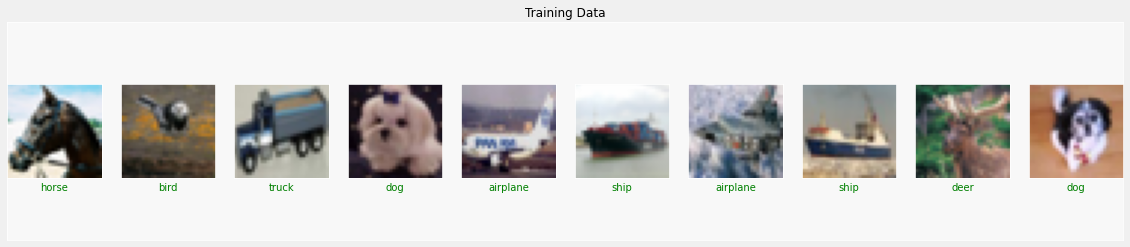

In [7]:
display_images(trainX_10, trainy_10, trainy_10, "Training Data" )

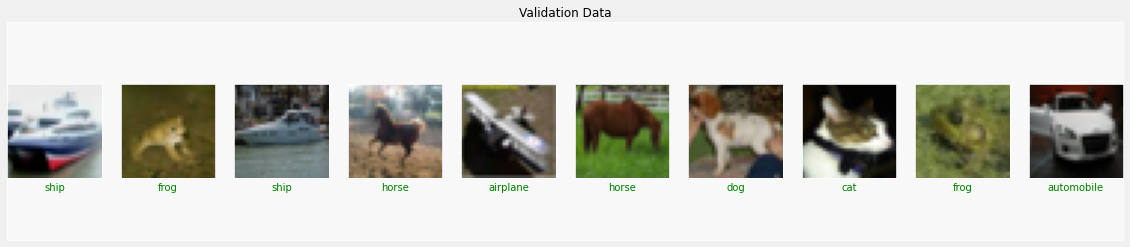

In [8]:
display_images(testX_10, testy_10, testy_10, "Validation Data" )

In [9]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = preprocess_input(input_images)
  return output_ims

In [10]:
x_train = preprocess_image_input(trainX_10)
x_test = preprocess_image_input(testX_10)

In [11]:
x_train.shape,len(x_train),x_train[4].shape

((5000, 32, 32, 3), 5000, (32, 32, 3))

In [12]:
y_train=trainy_10
y_test=testy_10
y_train.shape,y_test.shape

((5000, 1), (1000, 1))

In [53]:
def feature_extractor(inputs):

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
  TL_base.trainable = False 
  return TL_base(inputs)

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
  
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

model = define_compile_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                             

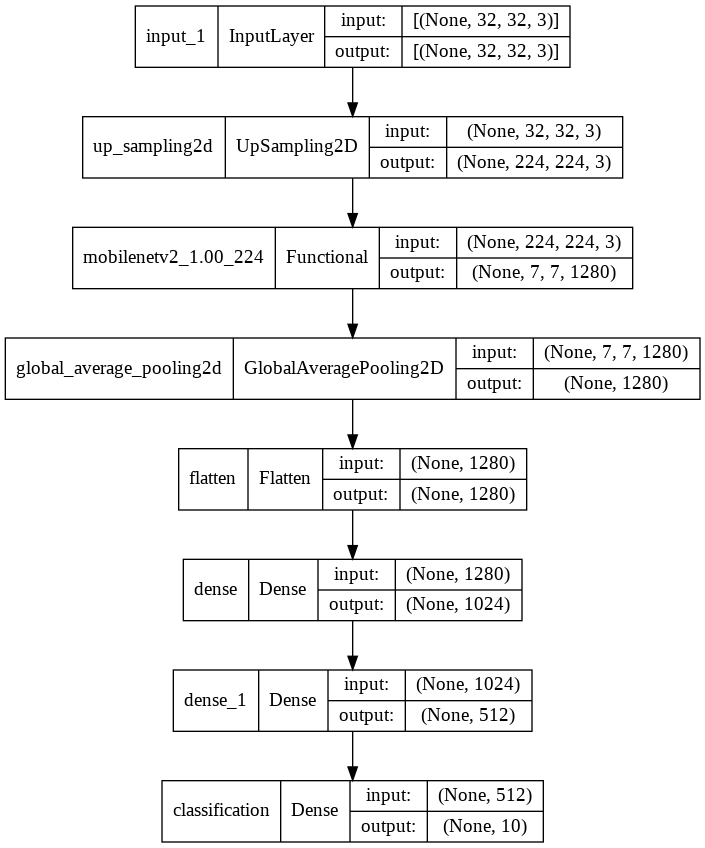

In [54]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_F.png')

In [14]:
from tensorflow.keras import layers, models, callbacks

mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10pct100_mobileNetV2F_SGD_best_weights.{epoch:03d}-{val_accuracy:.3f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [15]:
%%time
EPOCHS = 100
BATCH_SIZE = 50  # 32, 50, 64, 100
history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data = (x_test, y_test), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 1.6901 - accuracy: 0.4304

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 31s 197ms/step - loss: 1.6901 - accuracy: 0.4304 - val_loss: 1.3797 - val_accuracy: 0.5330
Epoch 2/100
100/100 [==============================] - 19s 187ms/step - loss: 1.2456 - accuracy: 0.5822 - val_loss: 1.2337 - val_accuracy: 0.5730
Epoch 3/100
100/100 [==============================] - 19s 188ms/step - loss: 1.0913 - accuracy: 0.6300 - val_loss: 1.1427 - val_accuracy: 0.5960
Epoch 4/100
100/100 [==============================] - 21s 210ms/step - loss: 1.0033 - accuracy: 0.6562 - val_loss: 1.0864 - val_accuracy: 0.6080
Epoch 5/100
100/100 [==============================] - 19s 188ms/step - loss: 0.9429 - accuracy: 0.6766 - val_loss: 1.0560 - val_accuracy: 0.6260
Epoch 6/100
100/100 [==============================] - 19s 188ms/step - loss: 0.8869 - accuracy: 0.6920 - val_loss: 1.0195 - val_accuracy: 0.6270
Epoch 7/100
100/100 [==============================] - 19s 188ms/step - loss: 0.8404 - accuracy: 0.7144 - val_loss: 1.0191 - val_accurac

In [16]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

20/20 [==============================] - 3s 151ms/step - loss: 0.9147 - accuracy: 0.6780


[0.9146589040756226, 0.6779999732971191]

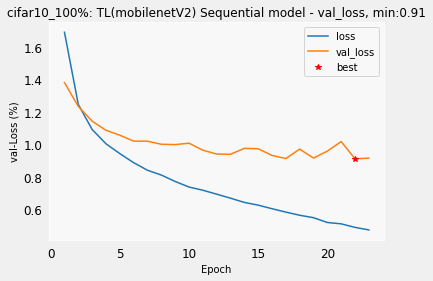

In [17]:
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss']
vloss_list = history.history['val_loss']

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],2)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

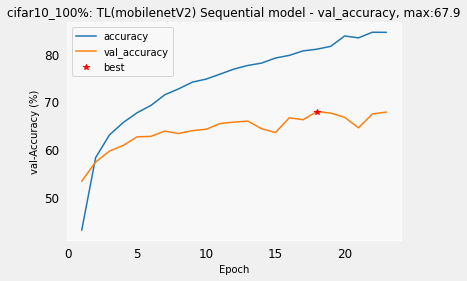

In [18]:
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],2)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

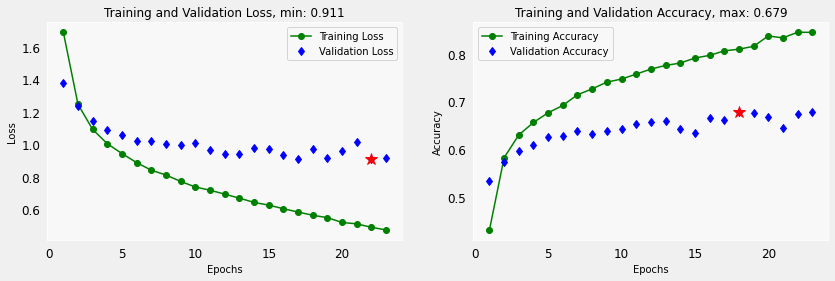

In [19]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

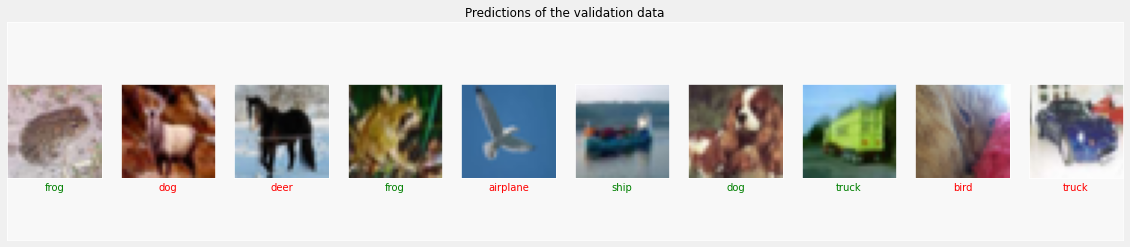

In [20]:
probabilities = model.predict(x_test, batch_size=BATCH_SIZE)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")

---

### Fine Tuning


In [21]:
tf.keras.backend.clear_session()

In [55]:
def feature_extractor_fine_tuning(inputs):

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')
  TL_base.trainable = True
  fine_tune_at = 107

  for layer in TL_base.layers[:fine_tune_at]:
    layer.trainable =  False

  return TL_base(inputs)

def final_model_ft(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    fine_feature_extractor = feature_extractor_fine_tuning(resize)
    classification_output = classifier(fine_feature_extractor)

    return classification_output

def define_compile_model_ft():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model_ft(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

model = define_compile_model_ft()

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d_1 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                           

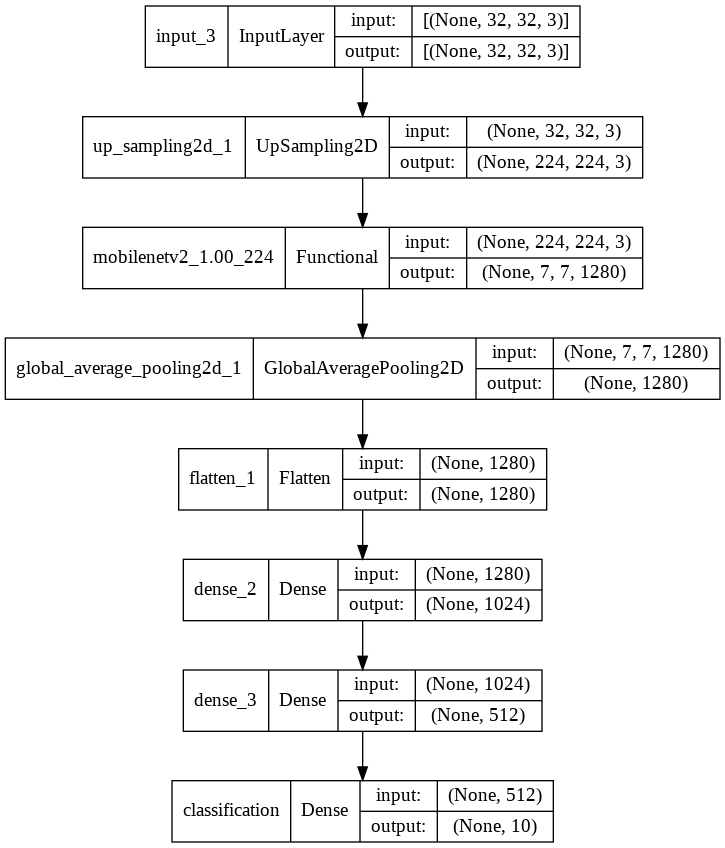

In [56]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_F.png')

In [23]:
from tensorflow.keras import layers, models, callbacks

In [24]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10pct100_mobileNetV2F_SGD_FT_best_weights.{epoch:03d}-{val_accuracy:.3f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [25]:
INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

In [26]:
%%time
BATCH_SIZE = 50
history_fine = model.fit(x_train, y_train, 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    validation_data = (x_test, y_test), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 24/123
100/100 [==============================] - ETA: 0s - loss: 1.4883 - accuracy: 0.5242

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 32s 281ms/step - loss: 1.4883 - accuracy: 0.5242 - val_loss: 1.7066 - val_accuracy: 0.4030
Epoch 25/123
100/100 [==============================] - 27s 272ms/step - loss: 0.6943 - accuracy: 0.7744 - val_loss: 1.6128 - val_accuracy: 0.4680
Epoch 26/123
100/100 [==============================] - 25s 249ms/step - loss: 0.4119 - accuracy: 0.8732 - val_loss: 1.6033 - val_accuracy: 0.4850
Epoch 27/123
100/100 [==============================] - 27s 271ms/step - loss: 0.2304 - accuracy: 0.9414 - val_loss: 1.5122 - val_accuracy: 0.5300
Epoch 28/123
100/100 [==============================] - 27s 271ms/step - loss: 0.1281 - accuracy: 0.9754 - val_loss: 1.4743 - val_accuracy: 0.5570
Epoch 29/123
100/100 [==============================] - 25s 249ms/step - loss: 0.0717 - accuracy: 0.9924 - val_loss: 1.4443 - val_accuracy: 0.5760
Epoch 30/123
100/100 [==============================] - 27s 271ms/step - loss: 0.0463 - accuracy: 0.9958 - val_loss: 1.5544 - val_a

In [47]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

20/20 [==============================] - 4s 152ms/step - loss: 0.9462 - accuracy: 0.7920


[0.9462365508079529, 0.7919999957084656]

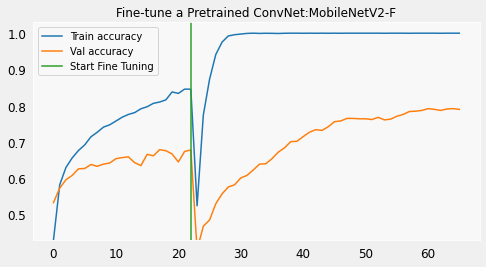

In [48]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')

plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:MobileNetV2-F")
plt.legend(loc='upper left')

plt.show()

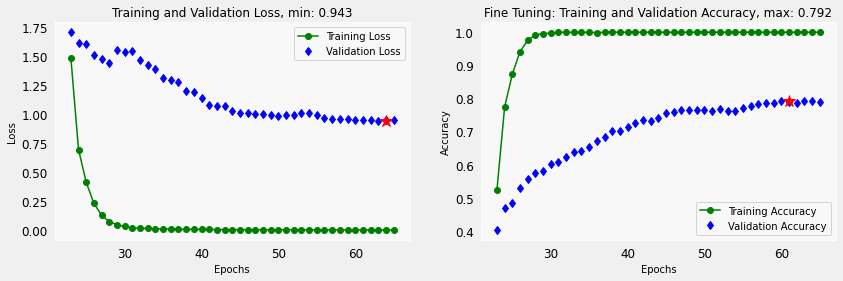

In [49]:
history_dict = history_fine.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(INITIAL_EPOCHS, INITIAL_EPOCHS+len(loss))

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(INITIAL_EPOCHS + np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')#, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(INITIAL_EPOCHS + np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Fine Tuning: Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

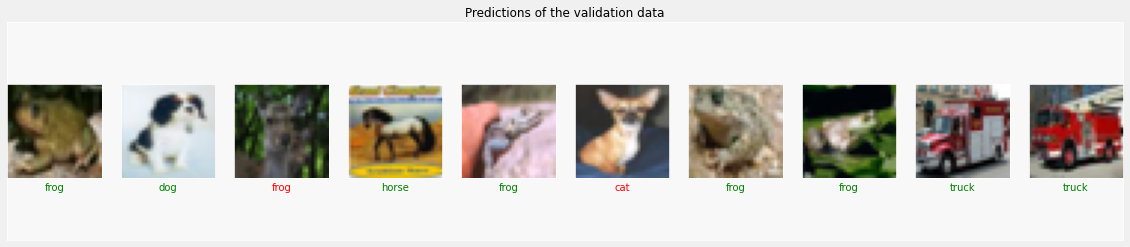

In [52]:
probabilities = model.predict(x_test, batch_size=BATCH_SIZE)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")

---

In [45]:
from keras.models import load_model

model = load_model('/content/model/cifar10pct100_mobileNetV2F_SGD_FT_best_weights.061-0.792.hdf5')
model.evaluate(x_test, y_test, batch_size=32)

32/32 [==============================] - 4s 104ms/step - loss: 0.9462 - accuracy: 0.7920


[0.9462364912033081, 0.7919999957084656]

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [33]:
predictions = model.predict(x_test)
predictions.shape

(1000, 10)

In [34]:
predictions0 = np.argmax(predictions, axis=1)
predictions0.shape

(1000,)

In [35]:
cm = confusion_matrix(y_test, predictions0)

In [36]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

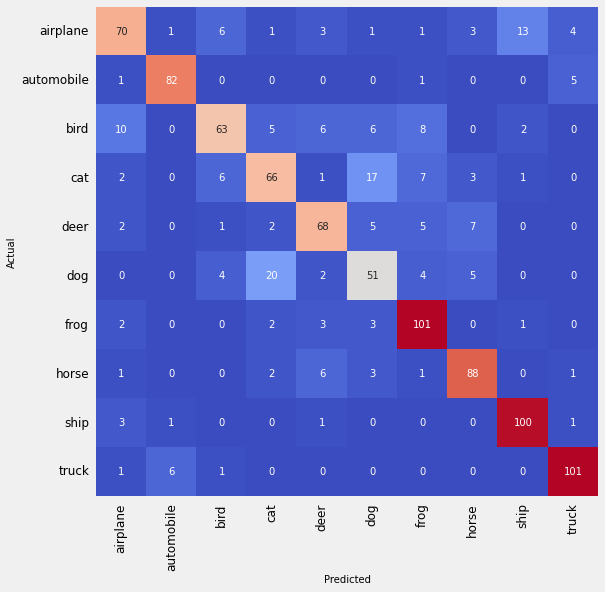

In [40]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [57]:
from sklearn.metrics import f1_score

print("f1_score : ",f1_score(y_test, predictions0,average="macro"))

f1_score :  0.7834286309921059


In [46]:
tf.keras.backend.clear_session()

---